In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch
import math

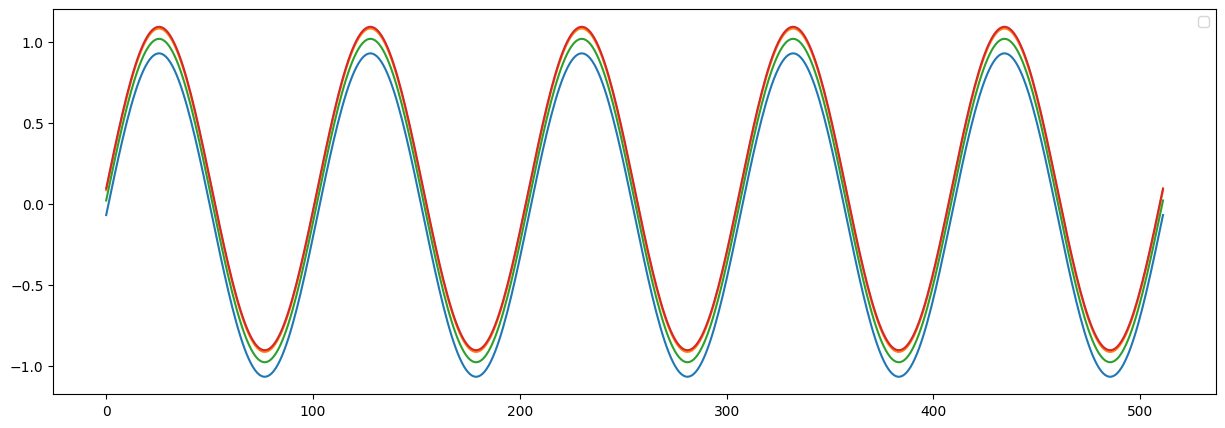

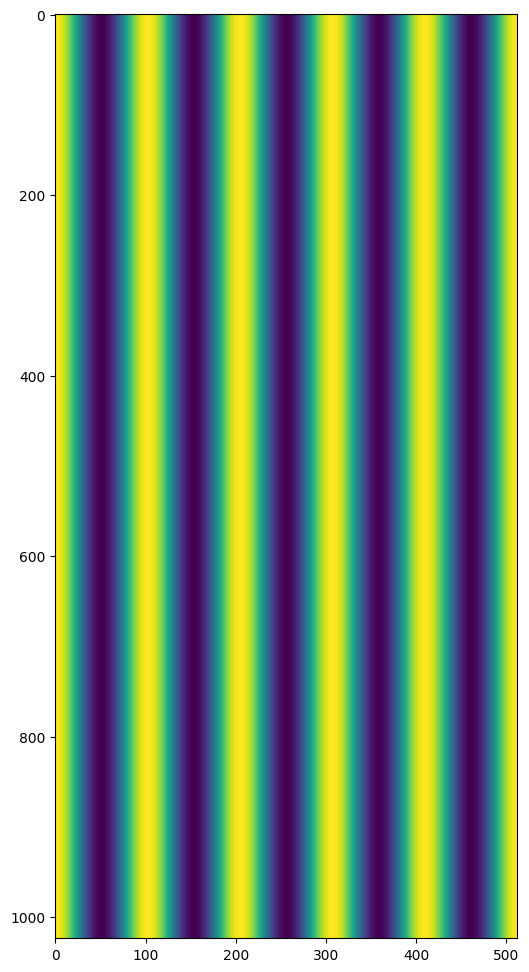

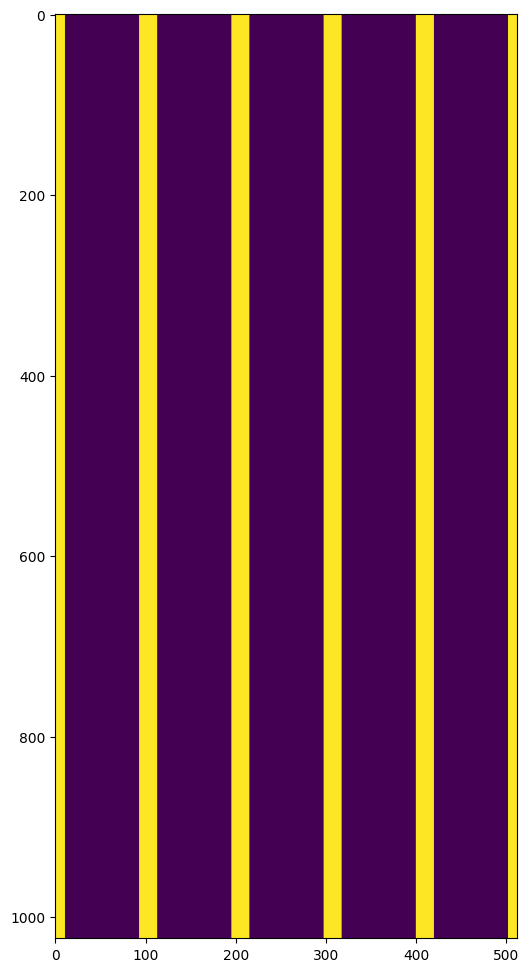

torch.Size([1024, 1, 512])


In [2]:
n = 5
r = 1024
x = torch.linspace(0, n*2*np.pi, 256*2)
x2 = x.unsqueeze(1).repeat_interleave(r, dim=1)
y = torch.sin(x2)
y += torch.normal(0., 0.1, size=(r,))

plt.figure(figsize=(15,5))
sns.lineplot(data=y[:,[1,2,3,4]].numpy(), dashes=False)
plt.legend([], [])
plt.show()

y_grad = torch.tensor(np.gradient(y, axis=0)).transpose(0, 1)

plt.figure(figsize=(12,12))
plt.imshow(y_grad.numpy())
plt.show()

label_mask = ((y_grad > .05) & (y_grad > -.05)) #.transpose()

plt.figure(figsize=(12,12))
plt.imshow(label_mask.numpy())
plt.show()

labels = label_mask.unsqueeze(1).to(torch.float32)
print(labels.shape)

In [3]:
data = y.transpose(0,1).unsqueeze(1)
display(data.shape)
a1 = nn.Conv1d(1, 3, 5, padding=2)(data)
display(a1.shape)
a2 = nn.Conv1d(3, 3, 5, padding=2)(a1)
display(a2.shape)
a3 = nn.MaxPool1d(2)(a2)
display(a3.shape)
a4 = nn.ConvTranspose1d(3, 3, 5, 2, padding=2, output_padding=1)(a3)
display(a4.shape)

torch.Size([1024, 1, 512])

torch.Size([1024, 3, 512])

torch.Size([1024, 3, 512])

torch.Size([1024, 3, 256])

torch.Size([1024, 3, 512])

In [4]:
def conv_out_size(conv_in, kernel_size, stride=1):
    # assumes no padding
    return math.floor((conv_in - (kernel_size - 1) - 1) / stride + 1)

def single_conv(in_channels, out_channels, kernel_size=3, pad=True):
    layer = nn.Sequential(
        nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size, 
            padding=0 if not pad else math.floor(kernel_size / 2),
        ),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(inplace=True),
    )
    return layer

def double_conv(in_channels, out_channels, **conv_kwargs):
    layer = nn.Sequential(
        single_conv(in_channels, out_channels, **conv_kwargs),
        single_conv(out_channels, out_channels, **conv_kwargs),
    )
    return layer

def triple_conv(in_channels, mid_channels, out_channels, **conv_kwargs):
    layer = nn.Sequential(
        single_conv(in_channels, mid_channels, **conv_kwargs),
        single_conv(mid_channels, mid_channels, **conv_kwargs),
        single_conv(mid_channels, out_channels, **conv_kwargs),
    )
    return layer

class Unet1d(nn.Module):
    def __init__(
        self, 
        init_upscale=8,
        n_blocks=3,
        depth_factor=3,
        kernel_size=3,
        stride=2,
        in_channels=1,
    ):
        super(Unet1d, self).__init__()
        self.conv_down_blocks = list()
        self.pool_down_layers = list()
        self.conv_up_blocks = list()
        self.tran_up_layers = list()
        assert kernel_size % 2

        self.input = single_conv(in_channels, init_upscale)
        channels = init_upscale
        for i in range(n_blocks):
            self.conv_down_blocks.append(
                double_conv(
                    channels, 
                    channels * depth_factor,
                )
            )
            channels *= depth_factor
            self.pool_down_layers.append(
                nn.MaxPool1d(stride)
            )
            
        self.mid_layer = triple_conv(channels, channels * depth_factor, channels)
        for i in range(n_blocks):
            self.tran_up_layers.append(
                nn.ConvTranspose1d(
                    channels, 
                    channels, 
                    kernel_size, 
                    stride,
                    padding=math.floor(kernel_size / 2),
                    output_padding=1,
                )
            )
            self.conv_up_blocks.append(
                triple_conv(
                    channels, # * 2
                    channels, 
                    channels // depth_factor,
                )
            )
            channels //= depth_factor
            
        self.output = single_conv(channels, 1)
        return
           
    def forward(self, x):
        original_shape = x.shape
        residuals = list()
        x = self.input(x)
        for conv_down_block, pool_down_layer in zip(self.conv_down_blocks, self.pool_down_layers):
            x = conv_down_block(x)
            residuals.append(x)
            x = pool_down_layer(x)
            
        x = self.mid_layer(x)
        for conv_up_block, residual, tran_up_layer in zip(self.conv_up_blocks, reversed(residuals), self.tran_up_layers):
            x = tran_up_layer(x)
            x = torch.add(x, residual)
            x = conv_up_block(x)

        x = self.output(x)
        assert x.shape == original_shape, f'{x.shape} != {original_shape}'
        x = torch.sigmoid(x)
        return x

# Bare Minimum to Prove it Trains
No train test split for the moment, just showing that it learns as expected, overfitting be damned. See other examples in parent repo for train/test/splits

In [5]:
def plot_pred_label(preds, labels):
    preds = preds.clone().squeeze(1).detach().numpy()
    labels = labels.squeeze(1).detach().numpy()
    
    plt.figure(figsize=(15,15))
    plt.plot(preds[0,:], label='pred')
    plt.plot(labels[0,:], label='label')
    plt.legend()
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
    ax1.imshow(preds)
    ax2.imshow(labels)
    plt.show()
    return

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

n_epochs = 380

model = Unet1d(n_blocks=5, kernel_size=17)

optimizer = optim.NAdam(model.parameters(), lr=.1)
# annealer = lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-5)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.MSELoss()

norm_data = (data - data.mean()) / data.std()
model_loss = list()
for epoch in range(n_epochs):
    if not epoch % 10:
        print(epoch, end='\r')
    optimizer.zero_grad()
    preds = model(norm_data)
#     print(preds.shape)
    
    if epoch > 0 and not epoch % 50:
        plot_pred_label(preds, labels)
#         pass
        
    loss = criterion(preds, labels)
    loss.backward()
    model_loss.append(loss.item())
    optimizer.step()
#     annealer.step()
    
plt.figure(figsize=(15,8))
plt.plot(model_loss)
plt.show()